# Entwicklungsaktivität in Bezug auf die verwendeten Technologien

Diese Analyse beschäftigt sich mit der Darstellung der Entwicklungsaktivitäten in Bezug auf die im Projekt verwendeten Technologien.
Sie werden pro Monat aggregiert dargestellt. Die verwendete Metrik sind die getätigten Commits, unabhängig von den Teilprojekten.
Ein Commit kann sich dabei auf mehrere Technologien beziehen.

## Laden relevanter Daten aus der Datenbank

Als erster Schritt werden die für die Analyse relevanten Daten aus der Datenbank geladen. Dabei erfolgt bereits eine Zuweisung an die verschiedenen Technologien des Projekts.

In [1]:
import shared.paths as paths
import shared.locals as locals
from datetime import datetime, timedelta
from tinydb import where
from helpers.config import Configuration
from database.database import Database
from database.models import Commit, Project

database = Database(paths.DATABASE_PATH, cached=True)
config = Configuration.from_input_file(paths.CONFIG_PATH)

start_date = datetime.utcfromtimestamp(config.start_timestamp)
limit_date = datetime.utcfromtimestamp(config.limit_timestamp)

delta = limit_date - start_date
months = {(start_date+timedelta(days=i)).date().replace(day=16) for i in range(delta.days + 1)}
years = {month.year for month in months}

technologies = config.technologies
results = {technology: {month: 0 for month in months} for technology in technologies}

for project in database.query(Project.LABEL, where("technologies") != []):
    for commit in database.query(Commit.LABEL, where("project_id") == project.id):
        date = datetime.utcfromtimestamp(commit.timestamp).date().replace(day=16)
        for technology in project.technologies:
            results[technology][date] += 1

## Visualisierung der Daten

Im zweiten Schritt werden die Daten anhand eines gestapelten Säulendiagramms dargestellt.

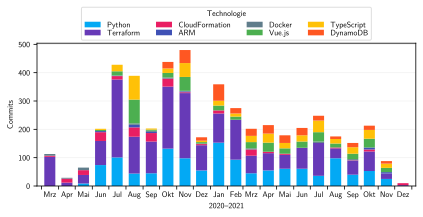

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.rc("font", **locals.FONT)
fig, ax = plt.subplots(figsize=(locals.TEXTWIDTH, 3.2))

for index, (technology, result) in enumerate(results.items()):
    values = list(result.values())
    
    if index == 0:
        bottom = None
    else:
        bottom = np.array(list(results[technologies[0]].values()))

        for previous_dataset in range(1, index):
            bottom += np.array(list(results[technologies[previous_dataset]].values()))
    
    ax.bar(list(months), values, bottom=bottom, width=20,
        color=locals.TECHNOLOGIES[technology]["color"], label=locals.TECHNOLOGIES[technology]["id"])

legend = ax.legend(title="Technologie", loc="upper center", bbox_to_anchor=(0.5, 1.28),
    ncol=4, labelspacing=0.1, columnspacing=2, edgecolor=locals.FRAME_GRAY)
legend._legend_box.sep = 4

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
ax.tick_params(axis="x", which="minor", bottom=False, top=False, labelbottom=True)

ax.margins(x=0.02)
ax.set_xlabel("2020–2021")
ax.set_ylabel("Commits")
ax.grid(axis="y", color=locals.GRID_GRAY)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

## Erstellung der Wertetabelle

Als letzter Schritt wird die entsprechende Wertetabelle zum Diagramm erstellt.

In [3]:
from IPython.display import display, HTML
from tabulate import tabulate

table_headers = ["Monat"]
table_headers.extend([locals.TECHNOLOGIES[technology]["id"] for technology in technologies])
table_rows = []

for month in sorted(months):
    row = [month.strftime("%b %Y")]
    for technology in technologies:
        row.append(results[technology][month])
    table_rows.append(row)

display(HTML(tabulate(headers=table_headers,
    tabular_data=table_rows,
    tablefmt="html", stralign="center", numalign="center")))

Monat,Python,Terraform,CloudFormation,ARM,Docker,Vue.js,TypeScript,DynamoDB
Mrz 2020,0,103,4,0,6,0,0,0
Apr 2020,0,12,14,0,3,0,0,0
Mai 2020,9,30,17,0,9,0,0,0
Jun 2020,74,85,31,4,0,4,4,0
Jul 2020,101,275,12,1,1,15,23,0
Aug 2020,44,130,33,9,5,84,84,0
Sep 2020,45,112,30,4,4,4,4,0
Okt 2020,132,219,28,0,4,16,16,23
Nov 2020,98,230,3,3,2,49,49,46
Dez 2020,55,89,4,0,2,5,5,12
